In [96]:
!pip install yfinance
!pip install ta

In [97]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import yfinance as yf
import matplotlib.pyplot as plt
from ta.volatility import BollingerBands
from ta.trend import MACD

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[*********************100%***********************]  5 of 5 completed


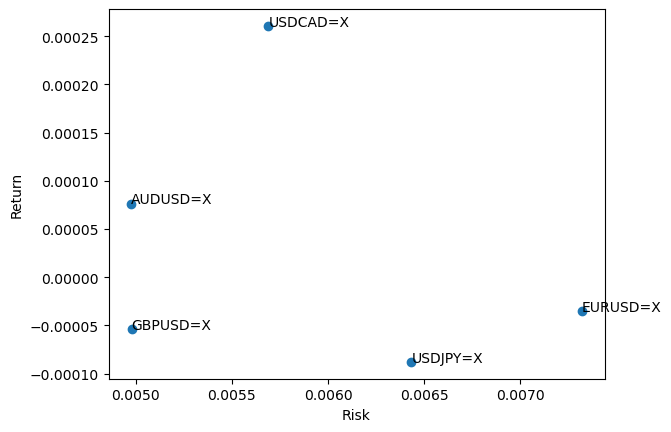

In [98]:

# create a list of ticker symbols
tickers = ["EURUSD=X", "GBPUSD=X", "USDJPY=X", "AUDUSD=X", "USDCAD=X"]

# download data for the tickers
data = yf.download(tickers, start="2020-01-01", end="2023-03-20")

# select the "Close" prices for each ticker
close_prices = data['Close']

# calculate daily returns
returns = close_prices.pct_change().dropna()

# calculate mean return and standard deviation for each ticker
mean_returns = returns.mean()
std_returns = returns.std()

# create a scatter plot of risk vs return for each ticker
plt.scatter(std_returns, mean_returns)

# annotate each data point with the corresponding ticker symbol
for i, txt in enumerate(tickers):
    plt.annotate(txt, (std_returns[i], mean_returns[i]))

# label the x and y axes
plt.xlabel('Risk')
plt.ylabel('Return')

# show the plot
plt.show()


In [99]:

class TradingStrategy:
    """
    A base class for implementing trading strategies.
    
    Attributes:
    -----------
    ticker : str
        The ticker symbol for the asset to be traded.
    start_date : str
        The start date for downloading historical price data.
    end_date : str
        The end date for downloading historical price data.
    data : pandas.DataFrame or None
        The historical price data for the asset, or None if not downloaded yet.
    signal_returns : pandas.Series or None
        The returns generated by the trading signal, or None if not generated yet.
    signal_returns_cumsum : pandas.Series or None
        The cumulative returns generated by the trading signal, or None if not generated yet.
    """
    
    def __init__(self, ticker, start_date, end_date):
        """
        Constructs a new TradingStrategy object with the specified parameters.
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.signal_returns = None
        self.signal_returns_cumsum = None
    
    def download_data(self):
        """
        Downloads the historical price data for the asset from Yahoo Finance.
        """
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        
    def plot_data(self):
        """
        Plots the historical price data for the asset.
        """
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(self.data['Close'], label='Close')
        ax.legend(loc='upper left')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.set_title(self.ticker)
        
    def generate_returns(self):
        """
        Generates the returns generated by the trading signal.
        This method should be implemented by subclasses.
        """
        pass

        
        
class MeanReversionStrategy(TradingStrategy):
    """
    A trading strategy based on mean reversion.

    Parameters:
    ticker (str): The ticker symbol for the currency pair.
    start_date (str): The start date for the strategy data in the format 'YYYY-MM-DD'.
    end_date (str): The end date for the strategy data in the format 'YYYY-MM-DD'.
    ma_window (int): The moving average window used for the mean reversion strategy. Default is 20.

    Attributes:
    ticker (str): The ticker symbol for the currency pair.
    start_date (str): The start date for the strategy data in the format 'YYYY-MM-DD'.
    end_date (str): The end date for the strategy data in the format 'YYYY-MM-DD'.
    data (pandas DataFrame): The strategy data for the currency pair.
    signal_returns (pandas Series): The signal returns generated by the strategy.
    signal_returns_cumsum (pandas Series): The cumulative sum of the signal returns.

    Methods:
    download_data(): Downloads the strategy data for the currency pair.
    plot_data(): Plots the strategy data for the currency pair.
    generate_mean_reversion_signals(): Generates the signal returns based on the mean reversion strategy.
    generate_returns(): Downloads the strategy data and generates the signal returns.
    run_strategy(): Alias for generate_returns().
    """
    
    def __init__(self, ticker, start_date, end_date, ma_window=20):
        """
        Constructs a MeanReversionStrategy object with the specified ticker, start date, end date, and moving average window.

        Args:
        ticker (str): The ticker symbol for the currency pair.
        start_date (str): The start date for the strategy data in the format 'YYYY-MM-DD'.
        end_date (str): The end date for the strategy data in the format 'YYYY-MM-DD'.
        ma_window (int): The moving average window used for the mean reversion strategy. Default is 20.
        """
        super().__init__(ticker, start_date, end_date)
        self.ma_window = ma_window
        
    def generate_mean_reversion_signals(self):
        """
        Generates the signal returns based on the mean reversion strategy.
        """
        self.data['MA'] = self.data['Close'].rolling(self.ma_window).mean()
        self.data['Signal'] = 0
        self.data.loc[self.data['Close'] > self.data['MA'], 'Signal'] = -1
        self.data.loc[self.data['Close'] < self.data['MA'], 'Signal'] = 1
        returns = self.data['Close'].pct_change()
        self.signal_returns = returns * self.data['Signal'].shift(1)
        self.signal_returns_cumsum = self.signal_returns.cumsum() 
        
    def generate_returns(self):
        """
        Downloads the strategy data and generates the signal returns.
        """
        self.download_data()
        self.generate_mean_reversion_signals()
        
    def run_strategy(self):
        """
        Alias for generate_returns().
        """
        self.generate_returns()

        
class BollingerBandsStrategy(TradingStrategy):
    def __init__(self, ticker, start_date, end_date, window=20, window_dev=2):
        super().__init__(ticker, start_date, end_date)
        self.window = window
        self.window_dev = window_dev
        
    def calculate_bollinger_bands(self):
        """
        Calculates the Bollinger Bands for the downloaded price data and assigns the upper, middle, and lower bands to the
        corresponding attributes of the class.
        """
        indicator_bb = BollingerBands(close=self.data["Close"], window=self.window, window_dev=self.window_dev)
        self.upper_band = indicator_bb.bollinger_hband()
        self.lower_band = indicator_bb.bollinger_lband()
        self.middle_band = indicator_bb.bollinger_mavg()
    
    def generate_signals(self):
        """
        Generates buy and sell signals based on the Bollinger Bands and assigns them to the self.data['Signal'] attribute.
        Also calculates the signal returns and assigns them to the self.signal_returns_cumsum attribute.
        """
        self.data['Signal'] = 0
        self.data.loc[self.data['Close'] > self.upper_band, 'Signal'] = 1
        self.data.loc[self.data['Close'] < self.lower_band, 'Signal'] = -1
        returns = self.data['Close'].pct_change()
        self.signal_returns = returns * self.data['Signal'].shift(1)  # Scale by 10 to make the visual more intuitive
        self.signal_returns_cumsum = self.signal_returns.cumsum() 
        
    def run_strategy(self):
        """
        Executes the Bollinger Bands trading strategy by calling the download_data(), calculate_bollinger_bands(),
        generate_signals(), and plot_data() methods in sequence.
        """
        self.download_data()
        self.calculate_bollinger_bands()
        self.generate_signals()
        #self.plot_data()

        


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Mean Reversion Returns:
{'AUDUSD=X': 85.05523256402068, 'USDCAD=X': 40.05381536116648, 'EURUSD=X': -2.2061044906945115, 'GBPUSD=X': -2.9581709343402323, 'USDJPY=X': -17.392035844962773}
Bollinger Bands Returns:
{'AUDUSD=X': 67.39516530608945, 'GBPUSD=X': 15.9907561664521, 'EURUSD=X': 14.400356357731342, 'USDJ

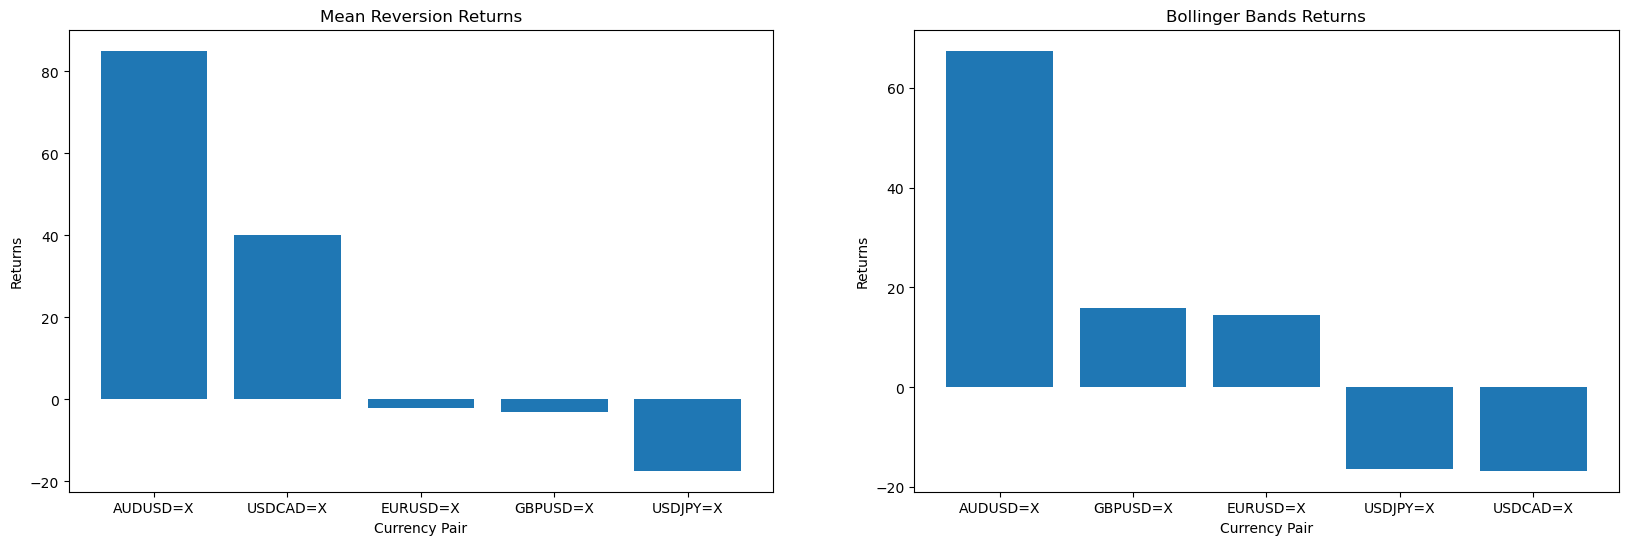

In [100]:
currencies = ["EURUSD=X", "GBPUSD=X", "USDJPY=X", "AUDUSD=X", "USDCAD=X"]
window = 10
start_date = '2020-01-01'
end_date = '2023-03-20'

# Mean Reversion strategy
mr_returns = {}
for currency in currencies:
    strategy = MeanReversionStrategy(ticker=currency, start_date=start_date, end_date=end_date, ma_window=window)
    strategy.run_strategy()
    mr_returns[currency] = strategy.signal_returns.cumsum().sum()

# Bollinger Bands strategy
bb_returns = {}
for currency in currencies:
    strategy = BollingerBandsStrategy(ticker=currency, start_date=start_date, end_date=end_date, window=window)
    strategy.run_strategy()
    bb_returns[currency] = strategy.signal_returns.cumsum().sum()

# Sort the returns dictionaries based on the highest return for each currency
sorted_mr_returns = {k: v for k, v in sorted(mr_returns.items(), key=lambda item: item[1], reverse=True)}
sorted_bb_returns = {k: v for k, v in sorted(bb_returns.items(), key=lambda item: item[1], reverse=True)}

# Print the sorted returns
print("Mean Reversion Returns:")
print(sorted_mr_returns)
print("Bollinger Bands Returns:")
print(sorted_bb_returns)

# Plot the returns for each currency using bar graphs
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].bar(sorted_mr_returns.keys(), sorted_mr_returns.values())
ax[0].set_xlabel('Currency Pair')
ax[0].set_ylabel('Returns')
ax[0].set_title('Mean Reversion Returns')
ax[1].bar(sorted_bb_returns.keys(), sorted_bb_returns.values())
ax[1].set_xlabel('Currency Pair')
ax[1].set_ylabel('Returns')
ax[1].set_title('Bollinger Bands Returns')
plt.show()
